In [3]:
### import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from utils import seir, modified_seir

# Exploring Scenarios
In order to explore regimes in which the two different vaccine failure mechanisms result in a significant difference, we quantified the impact of vaccine failure using the total recovered population. For each of the three vaccination scenarios (pre-transmission, 10 days post-transmission, 30 days post-transmission), the $R_0$ values were varied from 1.0 to 3.0, vaccine efficacy was varied from 1% effective to 100% effective, and for each $R_0$ value and vaccine efficacy, we used three different vaccination population values - below, slightly above, and above the critical vaccination level. Note that the $R_0$ values used are the values before intervention.

## Critical Vaccination Level ($V_c$)
The critical vaccination level is the proportion of the population that must be vaccinated in order to reach herd immunity, preventing further transmission of the disease. This value depends on how fast the disease spreads and how effective the vaccine is, as more people would need to get vaccinated if the disease had a high $R_0$ value and low vaccine efficacy. Note that the critical vaccination level cannot exceed 1.

$$ \text{Critical Vaccination Level ($V_c$)} = \frac{(1 - \frac{S}{R_0})}{\epsilon_L \epsilon_A} $$

Furthermore, vaccine coverage was varied based on the above critical vaccination level as follows, to investigate regimes where vaccination is insufficient, minimally sufficient, and exceedingly sufficient. 

$$ v_\text{below $V_c$} = V_c * 0.8$$
$$ v_\text{slightly above $V_c$} =  1 - ((1 - V_c) * 0.8) $$
$$ v_\text{above $V_c$} = 1 - ((1 - V_c) * 0.5) $$

We then calculated the percentage reduction of the total recovered population compared to that of without vaccination and plotted the difference in percentage reduction between the two vaccine failure mechanisms. The total recovered population was obtained by taking the last value of the $R$ class after running the simulation for 15,000 days.

Note that the other parameter values remain the same as the above time-series plots, and we also assume vaccination happens all at once.

## Pre-transmission Vaccination

In [10]:
### run model for various scenarios
# set parameters
sigma = 1/4; gamma = 1/4; f = 0
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0; 
D = 15000; t = np.arange(0, D+1)

# vary parameters
R0s = np.arange(1.0, 3.0, 0.01); df_R0s = []
epss = np.arange(0.01, 1.0, 0.01); df_epss = []
hits = ['Below HIT', 'Slightly Above HIT', 'Above HIT']; df_vmaxs = []; df_hits = []
df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []; df_sig = []

for R0 in R0s:
    beta = R0 * gamma
    sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
    s, e, i, r = sim.T
    
    r_tot = r[-1]
            
    for eps in epss:
        hit_val = (1-s0/R0) / (eps * 1)
        for hit in hits:
            if hit == 'Below HIT':
                vmax = hit_val * 0.8
            elif hit == 'Slightly Above HIT':
                vmax = 1 - ((1 - hit_val) * 0.8)
            else:
                vmax = 1 - ((1 - hit_val) * 0.5)

            # leaky
            epsL = eps; epsA = 1
            s0_vax = 0.98-vmax; v_es0_leaky = 0; v_rs0_leaky = vmax
            y0_vax_leaky = s0_vax, v_es0_leaky, v_rs0_leaky, e0, i0, r0
            sim_leaky = odeint(modified_seir, y0_vax_leaky, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_leaky, v_es_leaky, v_rs_leaky, e_leaky, i_leaky, r_leaky = sim_leaky.T

            r_tot_leaky = r_leaky[-1]
            r_perc_leaky = abs(r_tot - r_tot_leaky) / r_tot * 100

            # aon
            epsL = 1; epsA = eps
            s0_vax = 0.98-vmax; v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA
            y0_vax_aon = s0_vax, v_es0_aon, v_rs0_aon, e0, i0, r0
            sim_aon = odeint(modified_seir, y0_vax_aon, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_aon, v_es_aon, v_rs_aon, e_aon, i_aon, r_aon = sim_aon.T

            r_tot_aon = r_aon[-1]
            r_perc_aon = abs(r_tot - r_tot_aon) / r_tot * 100

            r_perc_diff = r_perc_aon - r_perc_leaky
            if r_perc_diff >= 2:
                df_sig.append('Yes')
            else:
                df_sig.append('No')

            df_R0s.append(R0)
            df_epss.append(eps)
            df_vmaxs.append(vmax)
            df_hits.append(hit)
            df_r_perc_leakys.append(r_perc_leaky)
            df_r_perc_aons.append(r_perc_aon)
            df_r_perc_diffs.append(r_perc_diff)

# build dataframe                        
df_timings = ['Pre' for i in df_R0s]

data = {'Vax Timing': df_timings, 'R0': df_R0s, 'VE': df_epss, 'Vax Population': df_hits, 'vmax': df_vmaxs, 'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs, 'Significant': df_sig}
pre_df = pd.DataFrame(data=data)

below_pre_df = pre_df[pre_df['Vax Population'] == 'Below HIT']
slabove_pre_df = pre_df[pre_df['Vax Population'] == 'Slightly Above HIT']
above_pre_df = pre_df[pre_df['Vax Population'] == 'Above HIT']

# reshape data for plotting
pre_plot_R0, pre_plot_VE = np.nan_to_num(np.meshgrid(R0s, epss, indexing='ij'))
pre_plot_diff_below = np.nan_to_num(np.reshape(below_pre_df['Diff'].to_numpy(), np.shape(pre_plot_R0)))
pre_plot_diff_slabove = np.nan_to_num(np.reshape(slabove_pre_df['Diff'].to_numpy(), np.shape(pre_plot_R0)))
pre_plot_diff_above = np.nan_to_num(np.reshape(above_pre_df['Diff'].to_numpy(), np.shape(pre_plot_R0)))

## 10 Days Post-Transmission Vaccination

In [11]:
### run model for various scenarios
# set parameters
sigma = 1/4; gamma = 1/4; f = 0
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0
D = 15000; D_vax = 10; t = np.arange(0, D+1); 
t_bfvax = np.arange(0, D_vax+1); t_aftvax = np.arange(D_vax, D+1)

# vary parameters
R0s = np.arange(1.0, 3.0, 0.01); df_R0s = []
epss = np.arange(0.01, 1.0, 0.01); df_epss = []
hits = ['Below HIT', 'Slightly Above HIT', 'Above HIT']; df_vmaxs = []; df_hits = []
df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []; df_sig = []

for R0 in R0s:
    beta = R0 * gamma
    sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
    s, e, i, r = sim.T
    
    r_tot = r[-1]
            
    sim_vax = odeint(seir, y0, t_bfvax, args=(beta, sigma, gamma))
    s0_vax, e0_vax, i0_vax, r0_vax = sim_vax.T

    for eps in epss:
        hit_val = (1-s0_vax[-1]/R0)/eps
        for hit in hits:
            if hit == 'Below HIT':
                vmax = hit_val * 0.8
            elif hit == 'Slightly Above HIT':
                vmax = 1 - ((1 - hit_val) * 0.8)
            else:
                vmax = 1 - ((1 - hit_val) * 0.5)

            # leaky
            epsL = eps; epsA = 1
            v_es0_leaky = 0; v_rs0_leaky = vmax
            y0_vax_leaky = s0_vax[-1] - vmax, v_es0_leaky, v_rs0_leaky, e0_vax[-1], i0_vax[-1], r0_vax[-1]
            sim_leaky = odeint(modified_seir, y0_vax_leaky, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_leaky, v_es_leaky, v_rs_leaky, e_leaky, i_leaky, r_leaky = sim_leaky.T

            r_tot_leaky = r_leaky[-1]
            r_perc_leaky = abs(r_tot - r_tot_leaky) / r_tot * 100

            # aon
            epsL = 1; epsA = eps
            v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA
            y0_vax_aon = s0_vax[-1] - vmax, v_es0_aon, v_rs0_aon, e0_vax[-1], i0_vax[-1], r0_vax[-1]
            sim_aon = odeint(modified_seir, y0_vax_aon, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_aon, v_es_aon, v_rs_aon, e_aon, i_aon, r_aon = sim_aon.T

            r_tot_aon = r_aon[-1]
            r_perc_aon = abs(r_tot - r_tot_aon) / r_tot * 100

            r_perc_diff = r_perc_aon - r_perc_leaky
            if r_perc_diff >= 2:
                df_sig.append('Yes')
            else:
                df_sig.append('No')

            df_R0s.append(R0)
            df_epss.append(eps)
            df_vmaxs.append(vmax)
            df_hits.append(hit)
            df_r_perc_leakys.append(r_perc_leaky)
            df_r_perc_aons.append(r_perc_aon)
            df_r_perc_diffs.append(r_perc_diff)
                        
# build dataframe
df_timings = ['Post 10' for i in df_R0s]

data = {'Vax Timing': df_timings, 'R0': df_R0s, 'VE': df_epss, 'Vax Population': df_hits, 'vmax': df_vmaxs, 'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs, 'Significant': df_sig}
post10_df = pd.DataFrame(data=data)

below_post10_df = post10_df[post10_df['Vax Population'] == 'Below HIT']
slabove_post10_df = post10_df[post10_df['Vax Population'] == 'Slightly Above HIT']
above_post10_df = post10_df[post10_df['Vax Population'] == 'Above HIT']

# reshape data for plotting
post10_plot_R0, post10_plot_VE = np.nan_to_num(np.meshgrid(R0s, epss, indexing='ij'))
post10_plot_diff_below = np.nan_to_num(np.reshape(below_post10_df['Diff'].to_numpy(), np.shape(post10_plot_R0)))
post10_plot_diff_slabove = np.nan_to_num(np.reshape(slabove_post10_df['Diff'].to_numpy(), np.shape(post10_plot_R0)))
post10_plot_diff_above = np.nan_to_num(np.reshape(above_post10_df['Diff'].to_numpy(), np.shape(post10_plot_R0)))

## 30 Days Post-Transmission Vaccination

In [12]:
### run model for various scenarios
# set parameters
sigma = 1/4; gamma = 1/4; f = 0
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0
D = 15000; D_vax = 30; t = np.arange(0, D+1); 
t_bfvax = np.arange(0, D_vax+1); t_aftvax = np.arange(D_vax, D+1)

# vary parameters
R0s = np.arange(1.0, 3.0, 0.01); df_R0s = []
epss = np.arange(0.01, 1.0, 0.01); df_epss = []
hits = ['Below HIT', 'Slightly Above HIT', 'Above HIT']; df_vmaxs = []; df_hits = []
df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []; df_sig = []

for R0 in R0s:
    beta = R0 * gamma
    sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
    s, e, i, r = sim.T
    
    r_tot = r[-1]
            
    sim_vax = odeint(seir, y0, t_bfvax, args=(beta, sigma, gamma))
    s0_vax, e0_vax, i0_vax, r0_vax = sim_vax.T

    for eps in epss:
        hit_val = (1-s0_vax[-1]/R0)/eps
        for hit in hits:
            if hit == 'Below HIT':
                vmax = hit_val * 0.8
            elif hit == 'Slightly Above HIT':
                vmax = 1 - ((1 - hit_val) * 0.8)
            else:
                vmax = 1 - ((1 - hit_val) * 0.5)

            # leaky
            epsL = eps; epsA = 1
            v_es0_leaky = 0; v_rs0_leaky = vmax
            y0_vax_leaky = s0_vax[-1] - vmax, v_es0_leaky, v_rs0_leaky, e0_vax[-1], i0_vax[-1], r0_vax[-1]
            sim_leaky = odeint(modified_seir, y0_vax_leaky, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_leaky, v_es_leaky, v_rs_leaky, e_leaky, i_leaky, r_leaky = sim_leaky.T

            r_tot_leaky = r_leaky[-1]
            r_perc_leaky = abs(r_tot - r_tot_leaky) / r_tot * 100

            # aon
            epsL = 1; epsA = eps
            v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA
            y0_vax_aon = s0_vax[-1] - vmax, v_es0_aon, v_rs0_aon, e0_vax[-1], i0_vax[-1], r0_vax[-1]
            sim_aon = odeint(modified_seir, y0_vax_aon, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_aon, v_es_aon, v_rs_aon, e_aon, i_aon, r_aon = sim_aon.T

            r_tot_aon = r_aon[-1]
            r_perc_aon = abs(r_tot - r_tot_aon) / r_tot * 100

            r_perc_diff = r_perc_aon - r_perc_leaky
            if r_perc_diff >= 2:
                df_sig.append('Yes')
            else:
                df_sig.append('No')

            df_R0s.append(R0)
            df_epss.append(eps)
            df_vmaxs.append(vmax)
            df_hits.append(hit)
            df_r_perc_leakys.append(r_perc_leaky)
            df_r_perc_aons.append(r_perc_aon)
            df_r_perc_diffs.append(r_perc_diff)

# build data frame                      
df_timings = ['Post 30' for i in df_R0s]

data = {'Vax Timing': df_timings, 'R0': df_R0s, 'VE': df_epss, 'Vax Population': df_hits, 'vmax': df_vmaxs, 'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs, 'Significant': df_sig}
post30_df = pd.DataFrame(data=data)

below_post30_df = post30_df[post30_df['Vax Population'] == 'Below HIT']
slabove_post30_df = post30_df[post30_df['Vax Population'] == 'Slightly Above HIT']
above_post30_df = post30_df[post30_df['Vax Population'] == 'Above HIT']

# reshape data for plotting
post30_plot_R0, post30_plot_VE = np.nan_to_num(np.meshgrid(R0s, epss, indexing='ij'))
post30_plot_diff_below = np.nan_to_num(np.reshape(below_post30_df['Diff'].to_numpy(), np.shape(post30_plot_R0)))
post30_plot_diff_slabove = np.nan_to_num(np.reshape(slabove_post30_df['Diff'].to_numpy(), np.shape(post30_plot_R0)))
post30_plot_diff_above = np.nan_to_num(np.reshape(above_post30_df['Diff'].to_numpy(), np.shape(post30_plot_R0)))

## Results

Based on the values obtained from above, we plotted the absolute value of the difference between the two vaccine failure mechanisms in the percentage reduction of the total recovered population. Note that the values were plotted based on a log-scale, but the colorbar on the right of each plot is labelled based on the actual values. 

### 3D Surface Plot

/var/folders/l5/z1zgtcc52355lzh_8yrfzxnw0000gn/T/ipykernel_18345/1168518839.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(np.round(np.exp(np.linspace(0.0, 4.0, 9))))


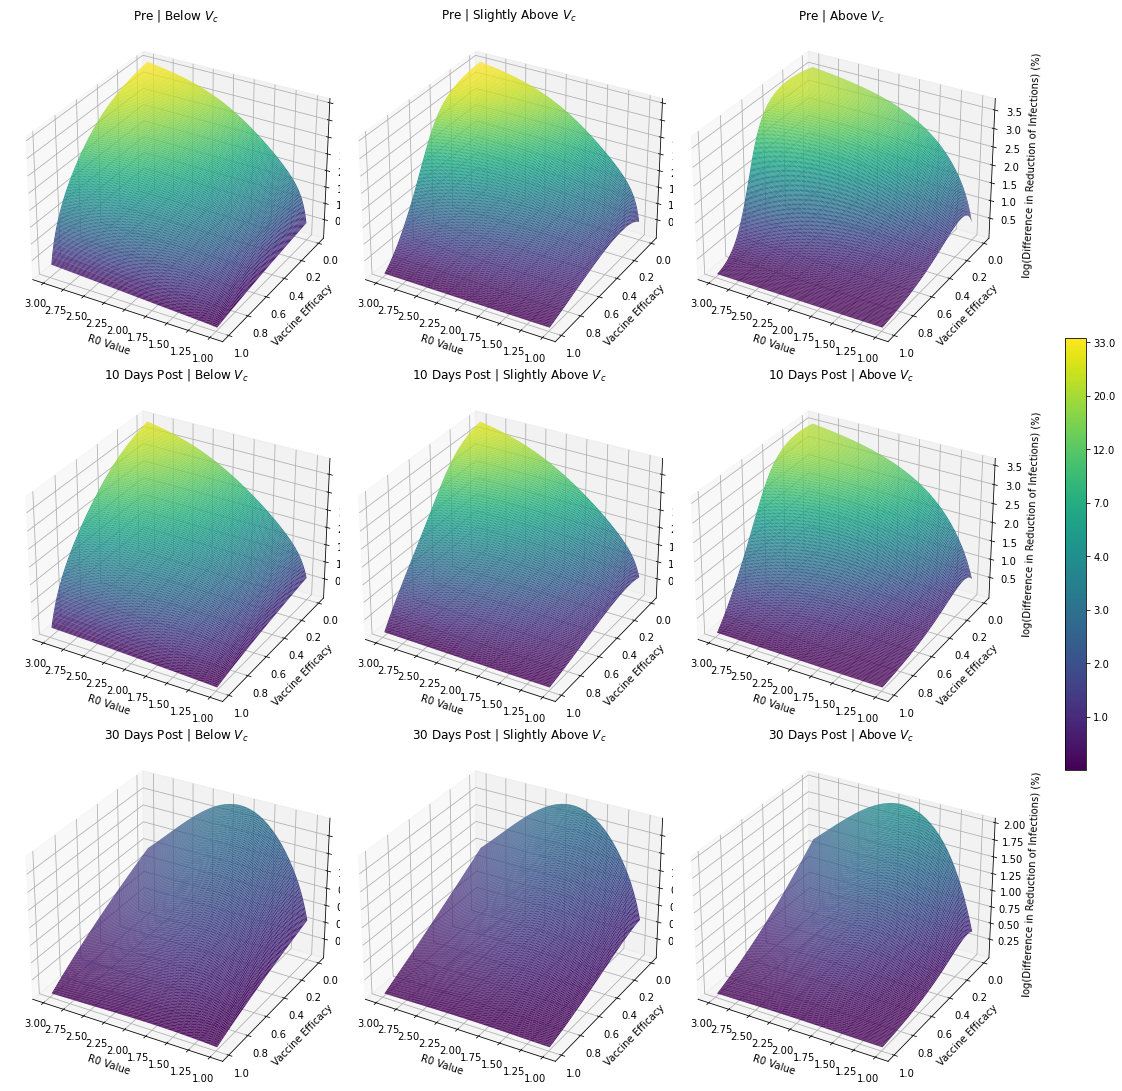

In [19]:
fig, axes = plt.subplots(3,3, facecolor='w', figsize=(15,15), gridspec_kw=dict(width_ratios=[1,1,1]), subplot_kw={'projection': '3d'})
norm = plt.Normalize(np.min(np.log(pre_plot_diff_below+1)), np.max(np.log(pre_plot_diff_below+1)))

# Pre-transmission
surf1 = axes[0,0].plot_surface(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_below+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[0,0].set_title('Pre | Below $V_c$')

axes[0,1].plot_surface(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_slabove+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[0,1].set_title('Pre | Slightly Above $V_c$')

axes[0,2].plot_surface(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_above+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[0,2].set_title('Pre | Above $V_c$')
axes[0,2].set_zlabel('log(Difference in Reduction of Infections) (%)')


# 10 days post-tranmission
axes[1,0].plot_surface(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_below+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[1,0].set_title('10 Days Post | Below $V_c$')

axes[1,1].plot_surface(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_slabove+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[1,1].set_title('10 Days Post | Slightly Above $V_c$')

axes[1,2].plot_surface(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_above+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[1,2].set_title('10 Days Post | Above $V_c$')
axes[1,2].set_zlabel('log(Difference in Reduction of Infections) (%)')

# 30 days post-transmission
axes[2,0].plot_surface(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_below+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[2,0].set_title('30 Days Post | Below $V_c$')

axes[2,1].plot_surface(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_slabove+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[2,1].set_title('30 Days Post | Slightly Above $V_c$')

axes[2,2].plot_surface(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_above+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[2,2].set_title('30 Days Post | Above $V_c$')
axes[2,2].set_zlabel('log(Difference in Reduction of Infections) (%)')

axs = np.array(axes)
for ax in axs.reshape(-1):
    ax.set_xlabel('R0 Value')
    ax.set_ylabel('Vaccine Efficacy')
    ax.view_init(elev=30, azim=120)


fig.tight_layout(pad=0.05)
cb = fig.colorbar(mappable=surf1, ax=axes, fraction=0.02, shrink=0.5)
cb.ax.set_yticklabels(np.round(np.exp(np.linspace(0.0, 4.0, 9))))
#plt.savefig('VE vs R0 Surface Plot', bbox_inches='tight')
plt.show()

### 2D Contour Plot

This plot is the 2D projection of the 3D surface plot above.

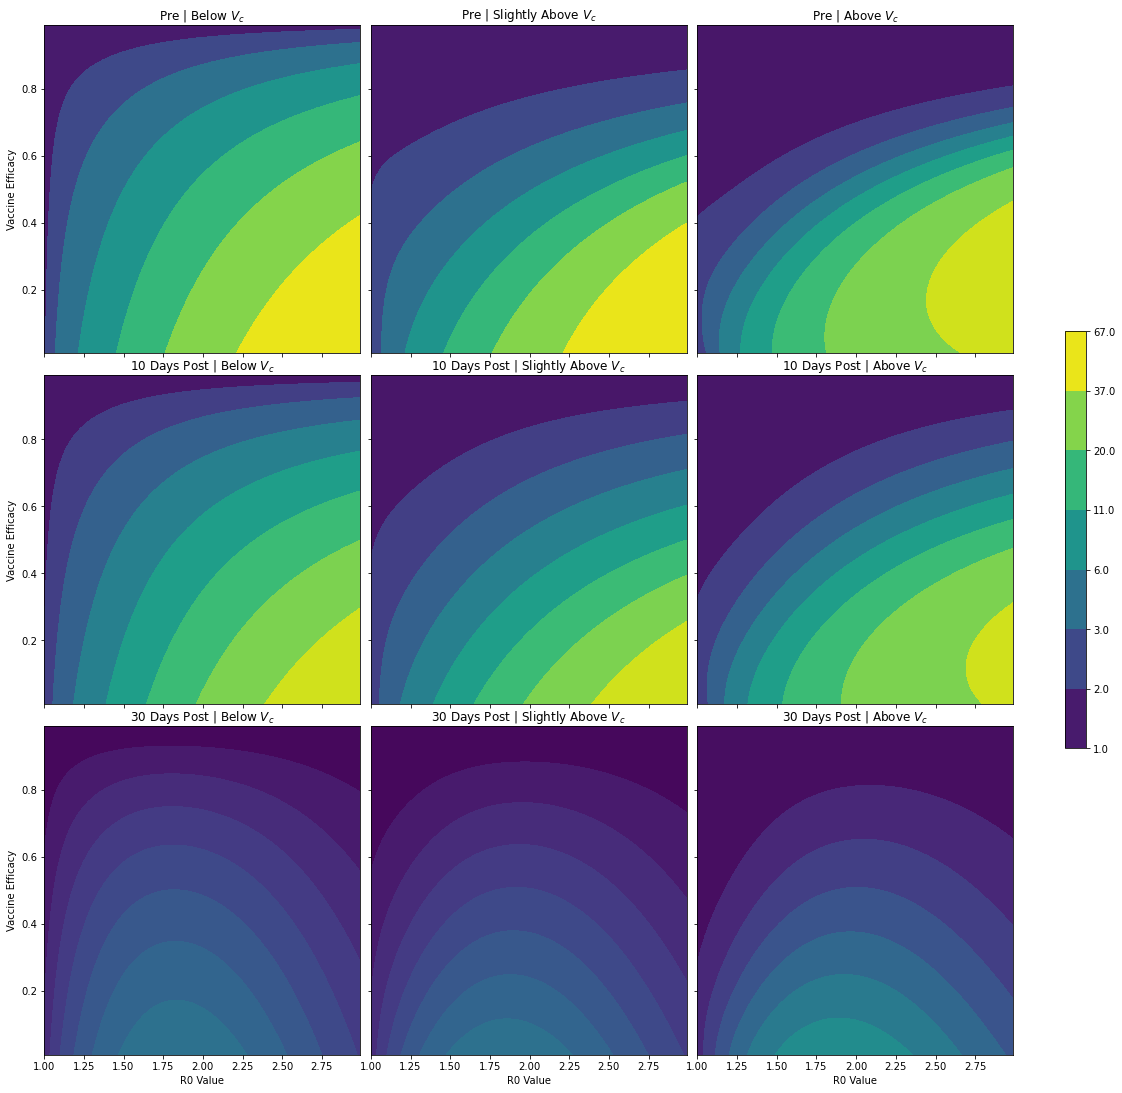

In [16]:
fig, axes = plt.subplots(3,3, facecolor='w', figsize=(15,15), sharex=True, sharey=True, gridspec_kw=dict(width_ratios=[1,1,1]))
norm = plt.Normalize(np.min(np.log(pre_plot_diff_below+1)), np.max(np.log(pre_plot_diff_below+1)))

# Pre-transmission 
proj = axes[0,0].contourf(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_below+1), norm=norm, cmap='viridis')
axes[0,0].set_title('Pre | Below $V_c$')
axes[0,0].set_ylabel('Vaccine Efficacy')

axes[0,1].contourf(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_slabove+1), norm=norm, cmap='viridis')
axes[0,1].set_title('Pre | Slightly Above $V_c$')

#ax3 = fig.add_subplot(133)
axes[0,2].contourf(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_above+1), norm=norm, cmap='viridis')
axes[0,2].set_title('Pre | Above $V_c$')

# 10 days post-transmission
axes[1,0].contourf(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_below+1), norm=norm, cmap='viridis')
axes[1,0].set_title('10 Days Post | Below $V_c$')
axes[1,0].set_ylabel('Vaccine Efficacy')

axes[1,1].contourf(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_slabove+1), norm=norm, cmap='viridis')
axes[1,1].set_title('10 Days Post | Slightly Above $V_c$')

axes[1,2].contourf(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_above+1), norm=norm, cmap='viridis')
axes[1,2].set_title('10 Days Post | Above $V_c$')

# 30 days post-transmission
axes[2,0].contourf(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_below+1), norm=norm, cmap='viridis')
axes[2,0].set_title('30 Days Post | Below $V_c$')
axes[2,0].set_ylabel('Vaccine Efficacy')
axes[2,0].set_xlabel('R0 Value')

axes[2,1].contourf(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_slabove+1), norm=norm, cmap='viridis')
axes[2,1].set_title('30 Days Post | Slightly Above $V_c$')
axes[2,1].set_xlabel('R0 Value')

axes[2,2].contourf(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_above+1), norm=norm, cmap='viridis')
axes[2,2].set_title('30 Days Post | Above $V_c$')
axes[2,2].set_xlabel('R0 Value')

fig.tight_layout(pad=0.05)
cb = fig.colorbar(mappable=proj, ax=axes, fraction=0.02, shrink=0.5)
cb.ax.set_yticklabels(np.round(np.exp(np.linspace(0.0, 4.2, 8))))
#plt.savefig('VE vs R0 2D Contour Plot', bbox_inches='tight')
plt.show()